<a href="https://colab.research.google.com/github/prashantiyaramareddy/MyPython-Stuff/blob/master/Pytorch/Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Model Deployment

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else


### 0. Get setup

In [1]:
### 1. Getting Data

# For this notebook to run with updated API's, we need torch 1.12+ and torchvision 0.13+

try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[0]) >= 13, "torch version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.9.0+cu128
torchvision version: 0.24.0+cu128


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it does not work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it works
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going_modular scripts
  print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub")
  !rm -rf pytorch-deep-learning
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep_learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 36.15 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting Data

The dataset we are going to use for deploying a FoodVision Mini model is ...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)


In [4]:
# Download pizza, steak, sushi images from Github
data_20_percent_path = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Set up training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

**FoodVision Mini ideal use case: * A model that performs well and fast

* Performs well: 95% + accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)

 * latency = time for prediction to take place

 To try and achieve these goals, we are going to build two model experiments
 1. EffNetB2 feature extractor
 2. ViT feature extractor

### 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning modelthat has its base layers frozen and output layers customized to a certain problem

https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights


In [6]:
import torchvision

# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
# 2. Get the transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# 4. Freeze base layers in the model ( this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

effnetb2

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth


100%|██████████| 35.2M/35.2M [00:00<00:00, 48.2MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [7]:
# 5. Update the classifier head
set_seeds()
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [8]:
from torchinfo import summary

summary(effnetb2, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [9]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [10]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)

from torchinfo import summary
summary(effnetb2, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])
#

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [11]:
### 3.1 Creating a function to make an EffNet B2 feature extractor
def create_effnetb2_feature_extractor(num_classes=3, seed=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in the base
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

In [12]:
effnetb2_model, effnetb2_transforms = create_effnetb2_feature_extractor(num_classes=3, seed=42)
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
#

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [14]:
effnetb2, effnetb2.transforms = create_effnetb2_feature_extractor(num_classes=3, seed=42)

In [15]:
effnetb2.transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [16]:
### 3.2 Setup DataLoaders
from going_modular.going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir = test_dir,
                                                                                                 transform = effnetb2_transforms,
                                                                                                 batch_size=32)
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor


In [17]:
from going_modular.going_modular import engine

# Setup hyperparameters
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(effnetb2_model.parameters(), lr=LEARNING_RATE)

# Training function (engine.py)
set_seeds()
effnetb2_results = engine.train(model=effnetb2_model,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=NUM_EPOCHS,
                                device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625
Epoch: 11 | train_loss: 0.3129 | train_acc: 0.8854 | test_loss: 0.2748 | test_acc: 0.9688
Epoch: 12 | train_l

### 3.4 Inspecting Loss Curves

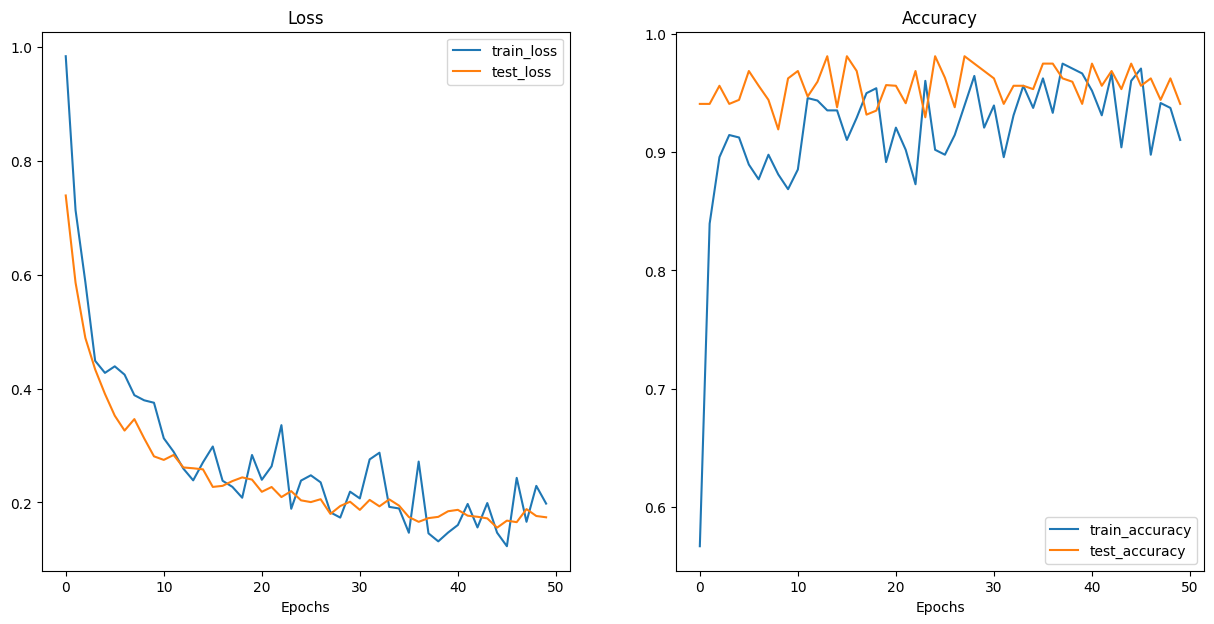

In [18]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [19]:
from going_modular.going_modular import utils

utils.save_model(model=effnetb2_model,
                 target_dir="models",
                 model_name="effnetb2_feature_extractor_20_percent.pth")

[INFO] Saving model to: models/effnetb2_feature_extractor_20_percent.pth


### 3.6 Inspecting the size of the EffNetB2 feature extractor

In [20]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
model_path = Path("models/effnetb2_feature_extractor_20_percent.pth")
Pretrained_model_size_bytes = model_path.stat().st_size

print(f"Model size: {Pretrained_model_size_bytes} bytes")
print(f"Model size: {Pretrained_model_size_bytes / (1024 * 1024)} megabytes")

Model size: 31290115 bytes
Model size: 29.84057903289795 megabytes


### 3.7. Collecting EffNetB2 feature extractor stats

We have got a few statistics about the EffNetB2 model such as test loss, test accuracy and model size, how about we collect all of them in a dictionary so we can compare them to the upcoming ViT feature extractor



In [21]:
# Count number of parameters in EffnetB2
effnetb2_total_params = sum([param.numel() for param in effnetb2_model.parameters()])
effnetb2_total_params

7705221

In [22]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {
    "test_loss": effnetb2_results['test_loss'][-1],
    "test_acc": effnetb2_results['test_acc'][-1],
    "model_size (MB)": Pretrained_model_size_bytes / (1024 * 1024),
    "num_params": effnetb2_total_params}

effnetb2_stats

{'test_loss': 0.17401890754699706,
 'test_acc': 0.940909090909091,
 'model_size (MB)': 29.84057903289795,
 'num_params': 7705221}

### 4. Creating a ViT feature extractor

In [23]:
# Check out ViT heads layer
vit = torchvision.models.vit_b_16(weights=None)
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [24]:
def create_vit_feature_extractor(num_classes=3, seed=42):
  # 1. Create ViT pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all layers in the model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs ( this will be trainable)
  torch.manual_seed(seed)
  model.heads = nn.Sequential(nn.Linear(in_features=768, out_features=num_classes))

  return model, transforms

In [25]:
# Create ViT model and transforms
vit_model, vit_transforms = create_vit_feature_extractor(num_classes=3, seed=42)
vit_model

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 105MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [26]:
# Get the summary of ViT feature extractor model
from torchinfo import summary

summary(vit_model,input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create data loaders for ViT


In [27]:
from going_modular.going_modular import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir = test_dir,
                                                                                       transform = vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT feature extractor


In [28]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-3)

# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Train ViT model
set_seeds()
vit_results = engine.train(model=vit_model,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           epochs=50,
                           device=device)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
Epoch: 11 | train_loss: 0.0592 | train_acc: 0.9854 | test_loss: 0.0606 | test_acc: 0.9938
Epoch: 12 | train_l

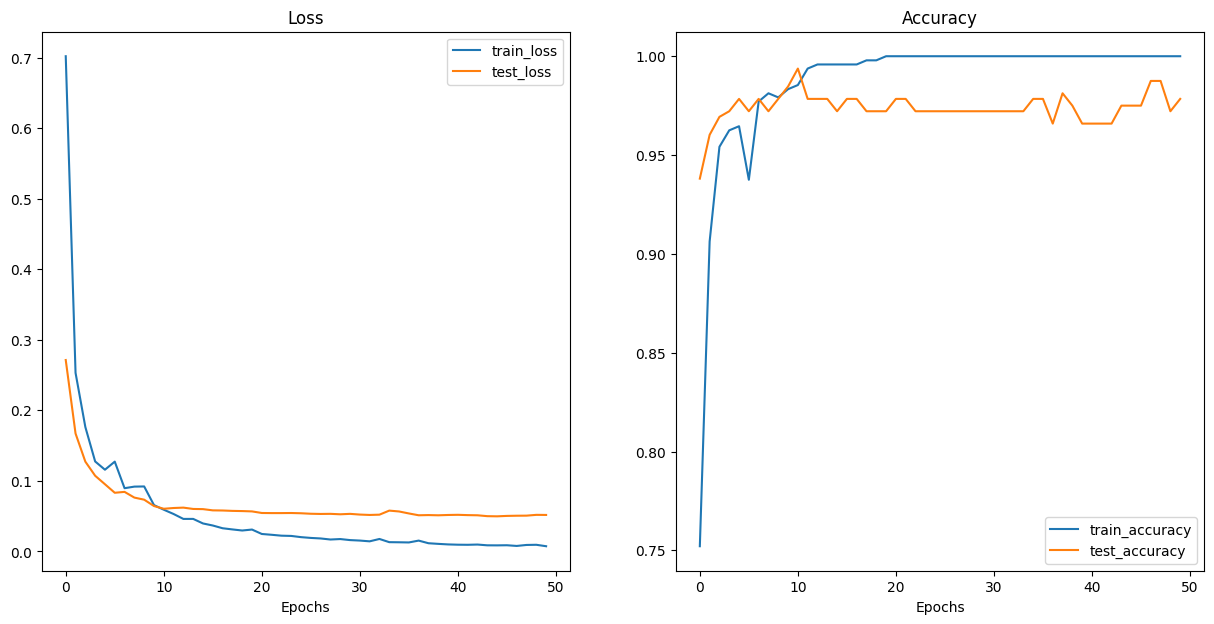

In [29]:
### 4.3 Inspecting ViT loss curves

from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor


In [30]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit_model,
                 target_dir="models",
                 model_name="vit_feature_extractor_20_percent.pth")

[INFO] Saving model to: models/vit_feature_extractor_20_percent.pth


### 4.5 Checking the size of ViT feature extractor

In [31]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_model_path = Path("models/vit_feature_extractor_20_percent.pth")
pretrained_model_size_bytes = pretrained_model_path.stat().st_size
pretrained_vit_model_size = pretrained_model_size_bytes / (1024 * 1024)

print(f"Model size: {pretrained_model_size_bytes} bytes")
print(f"Model size: {pretrained_vit_model_size} megabytes")
#

Model size: 343268605 bytes
Model size: 327.36645221710205 megabytes


### 4.6 Collecting ViT feature extractor stats


In [32]:
# Count number of parameters in ViT
vit_total_params = sum([param.numel() for param in vit_model.parameters()])
vit_total_params

85800963

In [33]:
# Create ViT statistics dictionary
vit_stats = {
    "test_loss": vit_results['test_loss'][-1],
    "test_acc": vit_results['test_acc'][-1],
    "model_size (MB)": pretrained_model_size_bytes,
    "number_of parameters":vit_total_params}

vit_stats

{'test_loss': 0.05178987846011296,
 'test_acc': 0.978409090909091,
 'model_size (MB)': 343268605,
 'number_of parameters': 85800963}

### 5. Making predictions with our trained models and timing them

Our Goal:
1. Perform well(95% + test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through the test images
2. Time how long each model takes to make a prediction on the image

Let's work towards making a function called `predandstore()` to do so

In [34]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]
#

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/44810.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/930553.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/420409.jpg')]

### 5.1 Creating a function to make across the test dataset

1. Create a function that takes a list of paths and a trained Pytorch and a series of transforms a list of target class names and a target device.
2. Create an empty list ( can return a full list of all predictions later).
3. Loop through the target input paths( the rest of the steps will take place inside the loop).
4. Create an empty disctionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on ` torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob +pred class.
11. Add the pred prob + pred class to empty disctionary from step 4.
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the prediction class matches the ground class.
14. Append the updated prediction dictionary to  the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries



In [40]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm

from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained Pytorch and a series of transforms a
# list of target class names and a target device and returns a list of dictionaries containing prediction stats
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names:List[str],
                   device:str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:



        # 2. Create an empty list ( can return a full list of all predictions later).
        pred_list = []

        # 3. Loop through the target input paths( the rest of the steps will take place inside the loop).
        for path in tqdm(paths):
          # 4. Create an empty disctionary for each sample (prediction statistics will go in here).
          pred_dict = {}

          # 5. Get the sample path and ground truth class from file path
          pred_dict['image_path'] = path
          pred_dict['class_name'] = path.parent.stem

          # 6. Start the prediction timer
          start_time = timer()

          # 7. Open the image using PIL.Image.open(path)
          img = Image.open(path)

          # 8. Transform the image to be usable with a given model.
          transformed_image = transform(img).unsqueeze(dim=0)

          # 9. Prepare the model for inference by sending to the target device and turning on eval() mode.
          model.to(device)
          model.eval()

          # 10. Turn on 'torch_inference_mode()` and pass the target transformed image to
          # the model and perform forward pass + calculate pred prob +pred class.
          with torch.inference_mode():
            pred_logits = model(transformed_image)
            pred_prob = torch.softmax(pred_logits, dim=1)
            pred_label = torch.argmax(pred_prob, dim=1)

          # 11. Add the pred prob + pred class to empty disctionary from step 4
          pred_dict['pred_prob'] = round(pred_prob.squeeze(0).max().cpu().item(),4)
          pred_dict['pred_class'] = class_names[pred_label.cpu()]

          # 12. End the prediction timer started in step 6 and the time to the prediction
          # dictionary
          end_time = timer()
          pred_dict['prediction_time'] = round(end_time - start_time,4)

        # 13. See if the prediction class matches the ground class.
          pred_dict['correct'] = pred_dict['pred_class'] == pred_dict['class_name']
          pred_list.append(pred_dict)

        # 14. Return the list of prediction dictionaries
        return pred_list

In [41]:
class_names,device

(['pizza', 'steak', 'sushi'], 'cuda')

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device = we are going to hardcode our predictions to happen on CPU (because you wont't always be sure of having a GPU when you deploy your model.)
2. Transforms - We want to make sure each of the models are predictiong on images that have been prepared with the appropriate transforms



In [46]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2_model,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device = "cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [47]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9968,
  'pred_class': 'pizza',
  'prediction_time': 0.1079,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9994,
  'pred_class': 'pizza',
  'prediction_time': 0.1017,
  'correct': True}]

In [48]:
# Turn the test_pred_dicts into a dataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()
#

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9968,pizza,0.1079,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9994,pizza,0.1017,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.8335,pizza,0.0965,True
3,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.8995,pizza,0.1002,True
4,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9289,pizza,0.0962,True


In [53]:
# Check the number of correct predictions
effnetb2_test_pred_df.correct.value_counts()


,count
correct,
True,141
False,9


In [55]:
# Find the average time for prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.prediction_time.mean(),4)
print(f"Average time per prediction: {effnetb2_average_time_per_pred} seconds")
#


Average time per prediction: 0.1042 seconds


**Note** Prediction times will vary(much like traing time) depending upon the hardware you are using

### 5.3. Making and timing predictions with ViT

We have made predictions with our EffNetB2 model, now let's do the same for our ViT model.

To do so, we can use the pred_and_store() function created above except this time we will pass in our ViT model as well as the vit_transforms.T_destination


In [56]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                      model = vit_model,
                                      transform=vit_transforms,
                                      class_names=class_names,
                                      device = "cpu")
#

  0%|          | 0/150 [00:00<?, ?it/s]

In [57]:
# Lets check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3729167.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9999,
  'pred_class': 'pizza',
  'prediction_time': 0.7116,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9998,
  'pred_class': 'pizza',
  'prediction_time': 0.5078,
  'correct': True}]

In [58]:
# Turn vit_test_pred_dicts to a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,prediction_time,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9999,pizza,0.7116,True
1,data/pizza_steak_sushi_20_percent/test/pizza/3...,pizza,0.9998,pizza,0.5078,True
2,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9964,pizza,0.5174,True
3,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9999,pizza,0.5056,True
4,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9985,pizza,0.5122,True


In [59]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,147
False,3


In [60]:
# Calculate the average time for prediction for ViT Model
vit_average_time_per_pred = round(vit_test_pred_df.prediction_time.mean(),4)
print(f"Average time per prediction: {vit_average_time_per_pred} seconds")
#

Average time per prediction: 0.6252 seconds


In [63]:
# Add average prediction time for ViT model on CPU
vit_stats['average_prediction_time'] = vit_average_time_per_pred
vit_stats
#

{'test_loss': 0.05178987846011296,
 'test_acc': 0.978409090909091,
 'model_size (MB)': 343268605,
 'number_of parameters': 85800963,
 'average_prediction_time': np.float64(0.6252)}

6. Comparing model results, prediction times and size

In [64]:
# Turn stat dictionaries into dataframes
df = pd.DataFrame([effnetb2_stats,vit_stats])
df
# Add column for model names
df['model_name'] = ['EffNetB2','ViT']

# Convert accuracy to percentage
df['test_acc'] = round(df['test_acc'] * 100,2)
df

,test_loss,test_acc,model_size (MB),num_params,number_of parameters,average_prediction_time,model_name
0,0.174019,94.09,2.984058e+01,7705221.0,NaN,NaN,EffNetB2
1,0.051790,97.84,3.432686e+08,NaN,85800963.0,0.6252,ViT


In [65]:
pd.DataFrame([effnetb2_stats,vit_stats])

,test_loss,test_acc,model_size (MB),num_params,number_of parameters,average_prediction_time
0,0.174019,0.940909,2.984058e+01,7705221.0,NaN,NaN
1,0.051790,0.978409,3.432686e+08,NaN,85800963.0,0.6252
